In [19]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import os, re, math, time, glob, pickle
import scipy.io as sio
import seaborn as sns
import matplotlib.pyplot as plt
import traj_dist.distance as tdist
import matplotlib.collections as mcoll
import fastcluster as fc
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import directed_hausdorff
from numba import jit

In [3]:
# Some visualization stuff, not so important
sns.set()
plt.rcParams['figure.figsize'] = (12, 12)

# Utility Functions
color_lst = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_lst.extend(['firebrick', 'olive', 'indigo', 'khaki', 'teal', 'saddlebrown',
                 'skyblue', 'coral', 'darkorange', 'lime', 'darkorchid', 'dimgray'])
Stages = [8, 10, 11, 12, 13, 14, 16, 18, 20, 22]
INDEX_RANGE = 139

In [4]:
def convert_data_into_np_array(data_save_pick_fp, load=True, number_of_pcs = 2):
    traj_list = []
    pair_indexs = range(1, INDEX_RANGE + 4)
    if load == False:
        STAGE_DATA_DIR = os.path.join(os.path.abspath(os.curdir), 'DATA', 'stage_data')
        Prob2d_DATA_DIR = os.path.join(os.path.abspath(os.curdir), 'DATA', 'stage_prob2d_data')
        data_dict = {}
        for dir_name in os.listdir(STAGE_DATA_DIR):
            if os.path.isdir(os.path.join(STAGE_DATA_DIR, dir_name)):
                dir_index = int(dir_name.split("_")[0])
                if dir_index <= INDEX_RANGE:
                    data_fp = os.path.join(STAGE_DATA_DIR, dir_name, "stage_metrics.csv")
                    df = pd.read_csv(data_fp, sep=",", header=0).values
                    data_dict[dir_index] = {}
                    data_dict[dir_index]['pair_name'] = '_'.join(re.sub(r'[\[|\]|\\|\'|\s]', '', df[0, 4]).split(','))
                    pcs = df[:, 7: 7 + number_of_pcs].astype(float)
                    data_dict[dir_index]['pcs'] = pcs

                    data_dict[dir_index]['prob2d'] = []
                    stage_prob2d_gene_pair_dir = os.path.join(Prob2d_DATA_DIR, dir_name)
                    for sid, stage in enumerate(Stages):
                        wild_card_path = os.path.join(stage_prob2d_gene_pair_dir, "Stage_%d_*.mat" % stage)
                        for filename in glob.glob(wild_card_path):
                            data_fp = os.path.join(stage_prob2d_gene_pair_dir, filename)
                            prob2d_arr = sio.loadmat(data_fp)
                            data_dict[dir_index]['prob2d'].append(prob2d_arr['prob2d'])

        pairs_name = ["sox2-t", "gata5-pax8", "lhx1-pax8"]
        for pid, pair in enumerate(pairs_name):
            base_dir = os.path.join(os.path.abspath(os.curdir), "DATA", "target_gene_pairs")
            input_fp = os.path.join(base_dir, pair + ".csv")
            pcs = pd.read_csv(input_fp, sep=",", header=0).values
            d_id = INDEX_RANGE + pid + 1
            data_dict[d_id] ={}
            data_dict[d_id]['pair_name'] = pair
            data_dict[d_id]['pcs'] = pcs
            data_dict[d_id]['prob2d'] = []

            stage_prob2d_gene_pair_dir = os.path.join(base_dir, pair)
            for sid, stage in enumerate(Stages):
                wild_card_path = os.path.join(stage_prob2d_gene_pair_dir, "Stage_%d_*.mat" % stage)
                for filename in glob.glob(wild_card_path):
                    data_fp = os.path.join(stage_prob2d_gene_pair_dir, filename)
                    prob2d_arr = sio.loadmat(data_fp)
                    data_dict[d_id]['prob2d'].append(prob2d_arr['prob2D'])
        with open(data_save_pick_fp, 'wb') as handle:
            pickle.dump(data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        with open(data_save_pick_fp, 'rb') as handle:
            data_dict = pickle.load(handle)
    for key in pair_indexs:
        traj = data_dict[key]['pcs']
        traj_list.append(traj)
        plt.plot(traj[:, 0], traj[:, 1])
    plt.show()
    return [data_dict, traj_list]

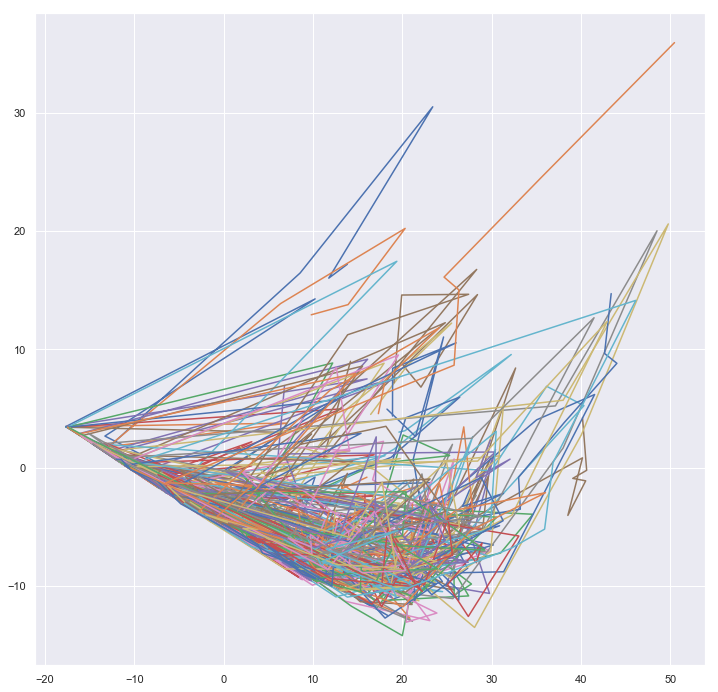

In [6]:
data_save_pick_fp = os.path.join(os.path.abspath(os.curdir), "DATA", "data_139.pkl")
[data_dict, traj_list] = convert_data_into_np_array(data_save_pick_fp, load=True)

In [7]:
def colorline(ax,
        x, y, z=None, linestyle = 'solid', cmap='gist_rainbow', norm=plt.Normalize(0.0, 1.0),
        linewidth=1, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    # to check for numerical input -- this is a hack
    if not hasattr(z, "__iter__"):
        z = np.array([z])

    z = np.asarray(z)
    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha, linestyle=linestyle)

    ax.add_collection(lc)

    return lc

In [8]:
def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

In [13]:
def hausdorff(u, v):
    d = max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0]) + np.linalg.norm(u - v) * 3
    return d

def calc_distance_matrix(distance_fp, traj_lst, metric_name):
    ts = time.time()
    #p_dist = pdist(traj_list, metric=metric_name)
#     nb_dist = len(p_dist)
    traj_count = len(traj_lst)
    D = np.zeros((traj_count, traj_count))

    # This may take a while
    for i in range(traj_count):
        for j in range(i + 1, traj_count):
            distance = hausdorff(traj_lst[i], traj_lst[j])
            D[i, j] = distance
            D[j, i] = distance
    te = time.time()
    print("%d Distances computed in %d seconds" % (traj_count, te - ts))
    np.save(distance_fp, D)

In [15]:
def plot_cluster(N_CLUSTER, traj_lst, cluster_lst, fig_fp):
    '''
    Plots given trajectories with a color that is specific for every trajectory's own cluster index.
    Outlier trajectories which are specified with -1 in `cluster_lst` are plotted dashed with black color
    '''

    N_COL = 5
    N_ROW = int(math.ceil(float(N_CLUSTER) / N_COL))
    c_arr = np.array([(time_point + 1.) / 10. for time_point in range(10)])
    traj_lst = np.array(traj_lst)
    cluster_lst = np.array(cluster_lst)
    fig, axs = plt.subplots(N_ROW, N_COL, figsize=(N_COL * EACH_SUB_FIG_SIZE, N_ROW * EACH_SUB_FIG_SIZE))
    for index, (traj, cluster) in enumerate(zip(traj_lst, cluster_lst)):
        row = cluster // N_COL
        col = cluster % N_COL
        if N_ROW > 1:
            ax = axs[row][col]
        else:
            ax = axs[cluster]
        data_index = index + 1
        if data_index > INDEX_RANGE:
            colorline(ax, traj[:, 0], traj[:, 1], c_arr, linestyle='dashed')
            ax.text(0, 0, data_dict[data_index]['pair_name'], color='black')
        else:

            colorline(ax, traj[:, 0], traj[:, 1], c_arr)
        ax.set_xlim(-20, 45)
        ax.set_ylim(-20, 40)
        ax.set_title("Cluster %d" % (cluster + 1))
    plt.savefig(fig_fp, dpi=200)
    plt.show()

In [16]:
def plot_heatmap_serie_of_each_cluster(data_dict, N_CLUSTER, cluster_lst, fig_dir):
    '''
    Plots given trajectories with a color that is specific for every trajectory's own cluster index.
    Outlier trajectories which are specified with -1 in `cluster_lst` are plotted dashed with black color
    '''
    data_dict = data_dict[0]
    N_COL = 10
    Max_NROW = 5
    TICKS = range(0, 21, 5)
    N_SUBFIG_PER_FIG = Max_NROW * N_COL
    cluster_lst = np.array(cluster_lst)
    for cluster in range(N_CLUSTER):
        gene_pair_indexs = np.where(cluster_lst == cluster)[0]
        n_gene_pairs_in_cluster = len(gene_pair_indexs)
        NFIG = int(math.ceil(float(n_gene_pairs_in_cluster) / Max_NROW))
        sub_fig_dir = os.path.join(fig_dir, "Cluster_%d" % (cluster + 1))
        mkdirs([sub_fig_dir])
        for i in range(NFIG):
            if NFIG > 1:
                fig_fp = os.path.join(sub_fig_dir, "Cluster_%d_%d.png" % (cluster + 1, i))
            else:
                fig_fp = os.path.join(sub_fig_dir, "Cluster_%d.png" % (cluster + 1))
            base_index = i * N_SUBFIG_PER_FIG
            N_remaining_files = n_gene_pairs_in_cluster * N_COL - base_index
            N_ROW = int(math.ceil(float(N_remaining_files) / N_COL)) if N_remaining_files <= N_SUBFIG_PER_FIG else Max_NROW
            plt.clf()
            fig, axs = plt.subplots(N_ROW, N_COL, figsize=(N_COL * EACH_SUB_FIG_SIZE, N_ROW * EACH_SUB_FIG_SIZE))
            SUB_FIG_RANGE = N_SUBFIG_PER_FIG if N_remaining_files > N_SUBFIG_PER_FIG else N_remaining_files
            plt.set_cmap('viridis_r')
            for j in range(SUB_FIG_RANGE):
                row = j // N_COL
                col = j % N_COL
                if N_ROW == 1:
                    ax = axs[col]
                else:
                    ax = axs[row][col]
                gene_pair_id = gene_pair_indexs[i * Max_NROW + row] + 1
                prob2d_array = data_dict[gene_pair_id]['prob2d']  # shape 21* 21
                prob2d = prob2d_array[col]
                q_potential = -np.log(np.abs(prob2d))
                cax = ax.pcolormesh(q_potential, vmin=3, vmax=14)
                ax.set_yticks(TICKS)
                ax.set_xticks(TICKS)
                if row == 0:
                    ax.set_title("Stage %d" % Stages[col])
                if col == 0:
                    ax.set_ylabel(data_dict[gene_pair_id]['pair_name'])
                if j == 0:
                    fig.colorbar(cax, ax=ax)
            plt.savefig(fig_fp, dpi=200)

In [17]:
def mkdirs(dir_paths):
    for dir_path in dir_paths:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)

### Calculating pair-wised trajactory distance

In [20]:
metric = "directed_hausdorff"
distance_fp = "DATA/pair_distance_by_%s_d_139_pairs.npy" % metric
calc_distance_matrix(distance_fp, traj_list, metric)

142 Distances computed in 1 seconds


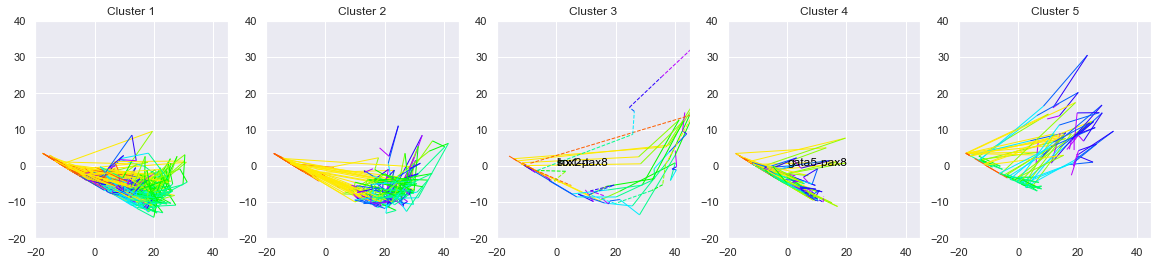

/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log


<Figure size 864x864 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x864 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1152 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x864 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

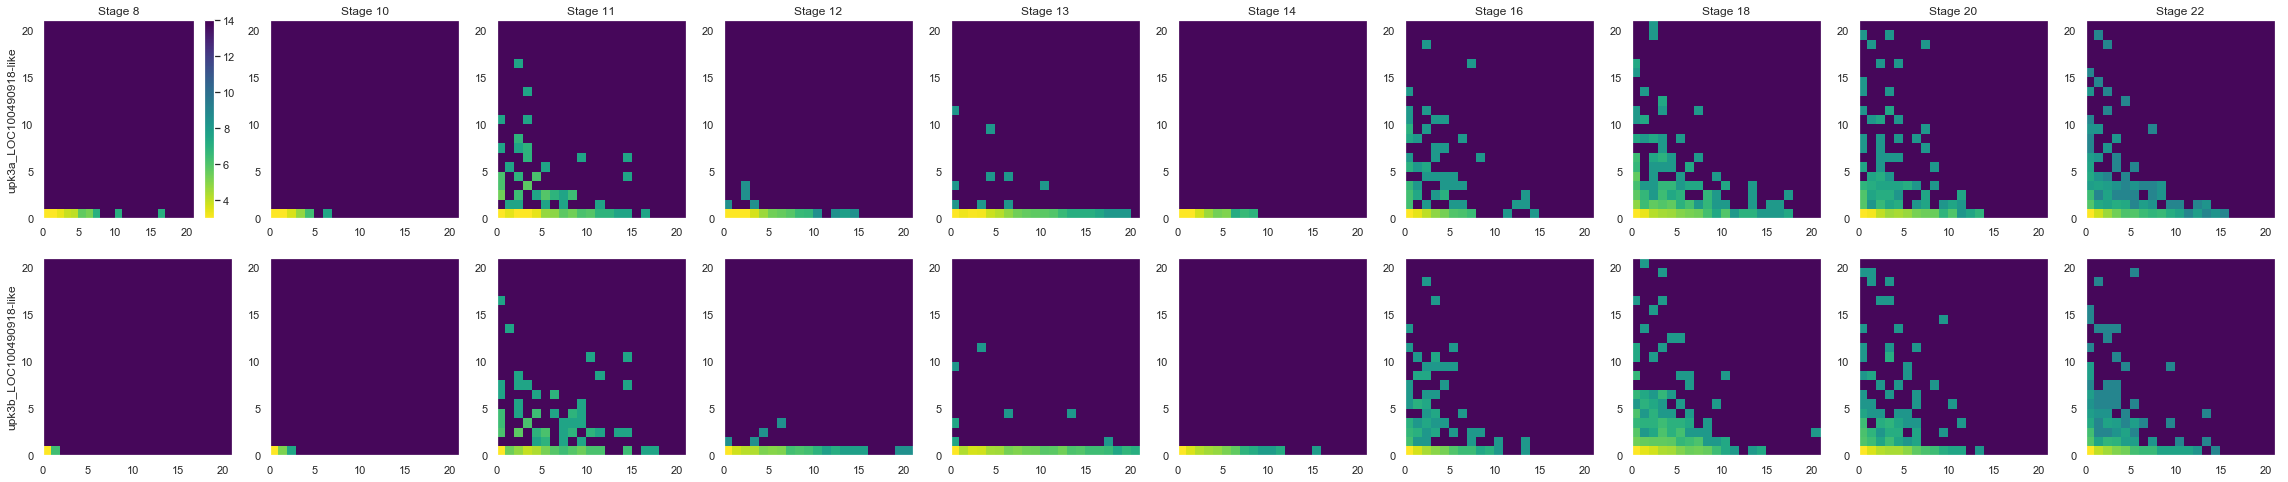

In [28]:
EACH_SUB_FIG_SIZE = 4
fig_dir = 'figure_outputs/Traj_clusters_139'
mkdirs([fig_dir])
fig_fp = os.path.join(fig_dir, "cluster_by_%s_139_pairs.png" % metric)
p_dist = np.load(distance_fp)
Z = fc.linkage(p_dist, method="ward")
labels = sch.fcluster(Z, t=2400, criterion="distance") - 1#2500
N_CLUSTER = len(np.unique(labels))
plot_cluster(N_CLUSTER, traj_list, labels, fig_fp)
plot_heatmap_serie_of_each_cluster([data_dict], N_CLUSTER, labels, fig_dir)